<a href="https://colab.research.google.com/github/Minghaooooo/Lake_Airplane/blob/main/Lake_or_airport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 挂载谷歌云盘 + 更改运行目录

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/Notebooks")

# 导包

In [ ]:
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pathlib

Tensorflow version: 2.15.0


# 配置数据集路径

In [ ]:
#配置数据集路径
path_root = os.path.join(os.path.realpath("."),"2_class")
data_dir = pathlib.Path(path_root)

#目录的数量
image_count = len(list(data_dir.glob('*/*.jpg')))
#显示类别
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])
print("数据集的数量:{}\n数据集的类别:{}".format(image_count,CLASS_NAMES))

#%%
# 打印该路径下的文件
for item in data_dir.iterdir():
    print(item)
import random
all_image_path = list(data_dir.glob("*/*"))
all_image_path = [str(path) for path in all_image_path]
random.shuffle(all_image_path)

数据集的数量:1400
数据集的类别:['lake' 'airplane']
/content/gdrive/MyDrive/ColabNotebooks/Notebooks/2_class/lake
/content/gdrive/MyDrive/ColabNotebooks/Notebooks/2_class/airplane


# 读取图像

In [ ]:
#%%确定每个图像的标签
lable_names = sorted(item.name for item in data_dir.glob("*/"))
#为每个标签分配索引,构建字典
lable_to_index = dict((name,index) for index,name in enumerate(lable_names))
print(lable_to_index)
#创建一个列表，包含每个文件的标签索引
all_image_label = [lable_to_index[pathlib.Path(path).parent.name] for path in all_image_path]

#包装为函数，以备后用
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image /= 255.0  # normalize to [0,1] range
    return image
#加载图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)



{'airplane': 0, 'lake': 1}


读取一个图像实例

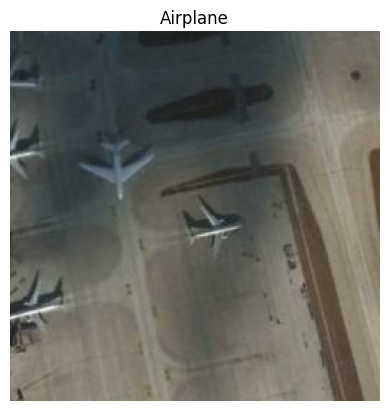

In [ ]:
image_path = all_image_path[50]
label = all_image_label[50]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
##plt.xlabel(caption_image(image_path))
plt.title(lable_names[label].title())
plt.axis("off")
print()

# 图像预处理
构建（图片，标签）与数据集

In [ ]:
#%%构建一个tf.data.Dataset
#一个图片数据集构建 tf.data.Dataset 最简单的方法就是使用 from_tensor_slices 方法。
#将字符串数组切片，得到一个字符串数据集：
path_ds =  tf.data.Dataset.from_tensor_slices(all_image_path)
print(path_ds)
#现在创建一个新的数据集，通过在路径数据集上映射 preprocess_image 来动态加载和格式化图片。
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = path_ds.map(load_and_preprocess_image,num_parallel_calls=AUTOTUNE)

lable_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_label,tf.int64))
for label in lable_ds.take(5):
    print(lable_names[label.numpy()])

#%%构建一个（图片，标签）对数据集
#因为这些数据集顺序相同，可以将他们打包起来
image_label_ds = tf.data.Dataset.zip((image_ds,lable_ds))
print(image_label_ds)

#注意：当你拥有形似 all_image_labels 和 all_image_paths 的数组，tf.data.dataset.Dataset.zip 的替代方法是将这对数组切片
# =================================im============================================
# ds = tf.data.Dataset.from_tensor_slices((all_image_path,all_image_label))
# def load_and_preprocess_from_path_label(path, label):
#     return load_and_preprocess_image(path),label
# image_label_ds = ds.map(load_and_preprocess_from_path_label)
# =============================================================================

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
lake
lake
airplane
lake
airplane
<_ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


设置训练数据与测试数据

In [ ]:
#%%设置训练数据和测试数据的大小
test_count = int(image_count*0.2)
train_count = image_count - test_count
print(test_count,train_count)
#跳过test_count个
train_dataset = image_label_ds.skip(test_count)
test_dataset = image_label_ds.take(test_count)

280 1120


# 训练阶段
对数据进行一定处理：
1.充分的打乱
2.分割成若干个batch
3.永远的重复

In [ ]:
batch_size = 32
# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据被充分打乱。
train_ds = train_dataset.shuffle(buffer_size=image_count).repeat().batch(batch_size)
test_ds = test_dataset.batch(batch_size)

构建模型

In [ ]:
#%%数据标准化
model = tf.keras.Sequential()   #顺序模型
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256, 256, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#%%
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc']
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 126, 126, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 61, 61, 128)       0         
 g2D)                                                   

开始训练

In [ ]:
steps_per_eooch = train_count//batch_size
validation_steps = test_count//batch_size

history = model.fit(train_ds,epochs=30,steps_per_epoch=steps_per_eooch,validation_data=test_ds,validation_steps=validation_steps)

Epoch 1/30
35/35 [==============================] - 151s 385ms/step - loss: 0.6712 - acc: 0.5625 - val_loss: 0.6385 - val_acc: 0.6055
Epoch 2/30
35/35 [==============================] - 13s 372ms/step - loss: 0.3424 - acc: 0.8848 - val_loss: 0.1979 - val_acc: 0.9375
Epoch 3/30
35/35 [==============================] - 13s 377ms/step - loss: 0.2363 - acc: 0.9348 - val_loss: 0.3269 - val_acc: 0.9336
Epoch 4/30
35/35 [==============================] - 14s 393ms/step - loss: 0.2188 - acc: 0.9411 - val_loss: 0.1403 - val_acc: 0.9570
Epoch 5/30
35/35 [==============================] - 13s 381ms/step - loss: 0.1087 - acc: 0.9661 - val_loss: 0.1548 - val_acc: 0.9453
Epoch 6/30
35/35 [==============================] - 13s 378ms/step - loss: 0.2638 - acc: 0.9277 - val_loss: 0.1414 - val_acc: 0.9336
Epoch 7/30
35/35 [==============================] - 13s 383ms/step - loss: 0.1645 - acc: 0.9563 - val_loss: 0.2149 - val_acc: 0.9336
Epoch 8/30
35/35 [==============================] - 13s 385ms/step -

结果

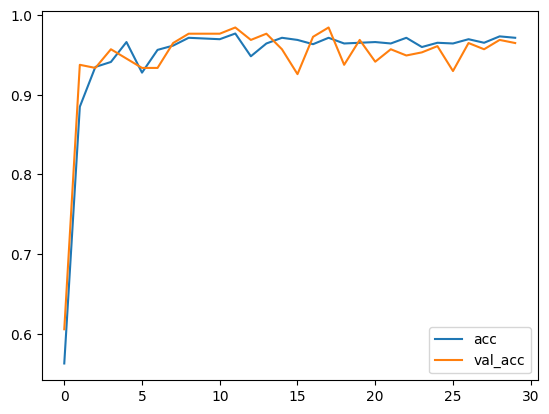

In [ ]:
history.history.keys()
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()
plt.show()


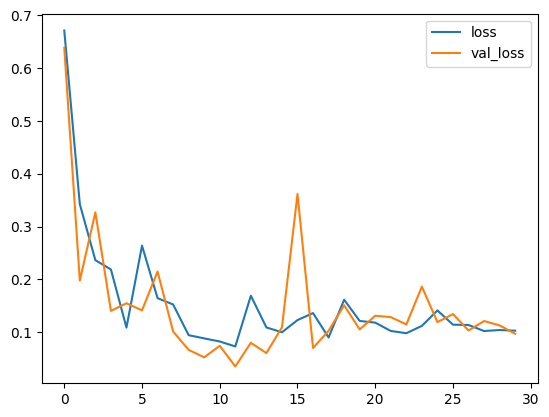

In [ ]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()


保存模型

In [ ]:
model.save("/content/gdrive/Othercomputers/Mycomputer/GoogleDrive")


# 对单个图片预测


/!\ /!\ /!\

In [ ]:
def predict_and_print(image_path):
    # 1. Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, (256, 256))  # Resize the image to (256, 256)

    # 2. Ensure the shape is (1, 256, 256, 3)
    image = tf.expand_dims(image, axis=0)

    # # 3. Load the pre-trained model
    # model = tf.keras.models.load_model(model_path)

    # 4. Predict
    predictions = model.predict(image)

    # 5. Process the prediction result
    predicted_class = predictions[0][0]

    if predicted_class == 1:
        plt.imshow(load_and_preprocess_image(image_path))
        plt.title('Predict: Lake')
        plt.axis("off")
        print()
    else:
        plt.imshow(load_and_preprocess_image(image_path))
        plt.title("Predict: Airplane")
        plt.axis("off")
        print()



1/1 [==============================] - 0s 18ms/step



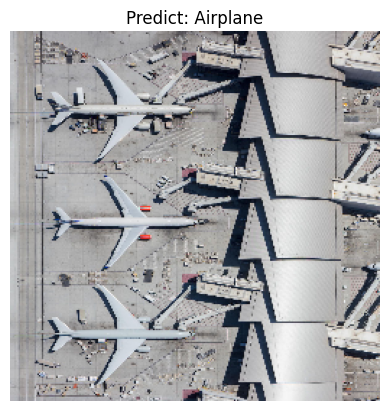

In [ ]:
# Example usage:
image_path = 'Lake_Airplane_test/Airplane02.png'
# model_path = 'your_model_path'  # Replace with the path to your saved model
predict_and_print(image_path)
